In [2]:
import pandas as pd
import numpy as np
import os
import joblib
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from scipy.optimize import curve_fit
import time
import tkinter as tk
from tkinter import messagebox
import math

# our functions
import seir_discrete 

import warnings
warnings.filterwarnings(action='ignore')

# для учета обновлений при изменении файлов
%load_ext autoreload
%autoreload 2

# Основная программа

In [3]:
def plot_one(ax, 
             predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta,
             seed_number, execution_time):
    '''
    Построение графика для seed.
    
    Параметры:

    - ax -- область для графика
    - predicted_days -- дни предсказания
    - seed_df -- DataFrame of seed, созданный регулярной сетью
    - predicted_I -- предсказанные траектория компартмента Infected
    - beggining_beta -- предсказанные начальные значения Beta
    - predicted_beta -- предсказанные значения Beta
    - seed_number -- номер seed        
    - execution_time - время предсказания Beta   
    '''
    # подсчет RMSE для значений Infected и Beta
    actual_I = seed_df.iloc[predicted_days[0]:]['I'].values 
    rmse_I = rmse(actual_I, predicted_I[0])
    actual_Beta = seed_df.iloc[predicted_days[0]:]['Beta'].values 
    rmse_Beta = rmse(actual_Beta, predicted_beta)   

    # Находим максимум и его индекс
    predicted_peak_I = max(predicted_I[0])
    max_index = np.argmax(predicted_I[0])
    predicted_peak_day = predicted_days[0] + max_index
    actual_peak_I = max(actual_I)
    actual_peak_day = np.argmax(actual_I)+1

    peak = [actual_peak_I, predicted_peak_I,actual_peak_day,predicted_peak_day] 

    # отображение границы перехода
    ax.axvline(predicted_days[0], color='red',ls=':')

    # отображение реальных и предсказанных значений Infected
    ax.plot(seed_df.index, seed_df.iloc[:]['I'].values , color='tab:blue', label='Actual I')
    ax.plot(predicted_days, predicted_I[0],color='blue', ls='--', 
                alpha=0.9, label='Predicted I (det.)')
    
    # отображение траекторий стохастической мат. модели
    for i in range(predicted_I.shape[0]-1):
        if i==0:
            label='Predicted I (stoch.)'
        else:
            label=''
            
        ax.plot(predicted_days, predicted_I[i+1], color='tab:blue', ls='--', 
                alpha=0.3, label=label)
    
    # добавление названий осей
    ax.set_xlabel('Days')
    ax.set_ylabel('Infected', color='blue')
    ax.grid(True, alpha=0.3)
        
    ax_b = ax.twinx()
    # отображение реальных и предсказанных значений beta
    ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='--', alpha=0.4, label='Actual Beta')
    
    if len(beggining_beta) > 0:
        given_days = np.arange(predicted_days[0])
        ax_b.plot(given_days, beggining_beta,color='green', ls='--', alpha=0.7,label='Predicted Beta ')
    ax_b.plot(predicted_days, predicted_beta,color='green', ls='--', alpha=0.7,label='Predicted Beta ')
    ax_b.set_ylabel("Beta", color='green')
    
    # добавление легенды и заголовков
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_b.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax.set_title(f'Seed {seed_number}, \n'+
                 f'Peak I (act.):{actual_peak_I:.2f}, Peak day (act.):{actual_peak_day:.2f}, \n' +
                 f'Peak I (pred.):{predicted_peak_I:.2f}, Peak day (pred.):{predicted_peak_day:.2f}, \n' +
                 f'RMSE I:{rmse_I:.2f}, RMSE beta:{rmse_Beta:.2e}, \n'+
                 f'Predict time: {execution_time:.2e}' ,fontsize=10)
    return rmse_I, rmse_Beta, peak
    
def load_saved_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    return joblib.load(model_path)

def predict_beta(I_prediction_method, seed_df, beta_prediction_method, predicted_days, 
                 stochastic, count_stoch_line, sigma, gamma):
    '''
    Предсказзание значений Beta.

    Параметры:

    - I_prediction_method -- математическая модель для предсказания траекторий Infected
        ['seir', 'sir']
    - seed_df -- DataFrame of seed, созданный регулярной сетью
    - beta_prediction_method -- метод предсказания значений Beta
        ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'expanding mean',
        'biexponential decay', 
        'median beta',
        'median beta;\nshifted forecast',
        'polynom (day)', 
        'polynom (day);\nshifted forecast',
        'regression (day)',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, previous I)',
        'lstm']
        ['last_value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)'

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, previous I)',       
        'lstm']
    - predicted_days -- дни предсказания
    - stochastic -- индикатор присутствия предсказанных стохастической мат. моделью траекторий Infected 
    - count_stoch_line -- количество предсказанных стохастической мат. моделью траекторий Infected 
    - sigma -- параметр мат. модели типа SEIR
    - gamma -- параметр мат. модели типа SEIR и SIR
    '''
    predicted_I = np.zeros((count_stoch_line+1, predicted_days.shape[0]))
    beggining_beta = []
    execution_time = 0
    start_time = time.time()

    if beta_prediction_method == 'last value':
        predicted_beta = [seed_df.iloc[predicted_days[0]]['Beta'] for i in range(predicted_days.shape[0])]

    elif beta_prediction_method == 'rolling mean last value':
        window_size = 7
        beggining_beta = seed_df.iloc[:predicted_days[0]]['Beta'].rolling(window=window_size).mean()
        predicted_beta = [beggining_beta.iloc[-1] for i in range(predicted_days.shape[0])]
    
    elif beta_prediction_method == 'expanding mean last value':
        betas = seed_df.iloc[:predicted_days[0]]['Beta'].mean()
        predicted_beta = [betas for i in range(predicted_days.shape[0])]

    elif beta_prediction_method == 'expanding mean':
        betas = seed_df.iloc[:]['Beta'].expanding(1).mean().values
        beggining_beta = betas[:predicted_days[0]]
        predicted_beta = betas[predicted_days[0]:]

    elif beta_prediction_method == 'biexponential decay':
        def biexponential_decay_func(x,a,b,c): 
            return a*(np.exp(-b*x)- np.exp(-c*x))
        given_betas = seed_df.iloc[:predicted_days[0]]['Beta'].values
        given_days = np.arange(predicted_days[0])
        coeffs, _ = curve_fit(biexponential_decay_func, given_days, given_betas)
        beggining_beta = biexponential_decay_func(given_days, *coeffs)
        predicted_beta = biexponential_decay_func(predicted_days, *coeffs)
        predicted_beta[predicted_beta < 0] = 0
        
    elif beta_prediction_method == 'median beta':
        betas = pd.read_csv('median_beta.csv', index_col=0)
        beggining_beta = betas.values[:predicted_days[0]].reshape(-1,)
        predicted_beta = betas.values[predicted_days[0]:].reshape(-1,)

    elif beta_prediction_method == 'median beta;\nshifted forecast':
        betas = pd.read_csv('median_beta.csv', index_col=0)
        beggining_beta = betas.values[:predicted_days[0]].reshape(-1,)
        predicted_beta = betas.values[predicted_days[0]:].reshape(-1,)
        change = seed_df['Beta'].rolling(14).mean()[predicted_days[0]]
        beggining_beta = beggining_beta + np.sign(change - predicted_beta[0]) * (np.abs(change - predicted_beta[0]))
        predicted_beta = predicted_beta + np.sign(change - predicted_beta[0]) * (np.abs(change - predicted_beta[0]))

    elif beta_prediction_method == 'polynom (day)':
        if I_prediction_method == 'seir':
            model_path = 'polynom_day_for_seir.joblib'
        else: 
            model_path = 'polynom_day_for_sir.joblib'
        # загрузка модели
        model = load_saved_model(model_path)
        # предсказываем значения Beta на оставшиеся дни
        x_test = np.arange(0,predicted_days[0]).reshape(-1, 1)
        beggining_beta = np.exp(model.predict(x_test))
        x_test = np.arange(predicted_days[0], seed_df.shape[0]).reshape(-1, 1)
        predicted_beta = np.exp(model.predict(x_test))

    elif beta_prediction_method == 'polynom (day);\nshifted forecast':
        if I_prediction_method == 'seir':
            model_path = 'polynom_day_for_seir.joblib'
        else: 
            model_path = 'polynom_day_for_sir.joblib'
        # загрузка модели
        model = load_saved_model(model_path)
        # предсказываем значения Beta на оставшиеся дни
        x_test = np.arange(0,predicted_days[0]).reshape(-1, 1)
        beggining_beta = np.exp(model.predict(x_test))
        x_test = np.arange(predicted_days[0], seed_df.shape[0]).reshape(-1, 1)
        predicted_beta = np.exp(model.predict(x_test))
        given_betas = seed_df.iloc[predicted_days[0]]['Beta']
        beggining_beta = beggining_beta  + np.sign(given_betas - predicted_beta[0]) * (np.abs(given_betas - predicted_beta[0]))
        predicted_beta = predicted_beta  + np.sign(given_betas - predicted_beta[0]) * (np.abs(given_betas - predicted_beta[0]))

    elif beta_prediction_method == 'regression (day)':
        if I_prediction_method == 'seir': 
            model_path = 'regression_day_for_seir.joblib'
        else: 
            model_path = 'regression_day_for_sir.joblib'
        model = load_saved_model(model_path)
        x_test = np.arange(0,predicted_days[0]).reshape(-1, 1)
        beggining_beta = np.exp(model.predict(x_test))
        x_test = np.arange(predicted_days[0], seed_df.shape[0]).reshape(-1, 1)
        predicted_beta = np.exp(model.predict(x_test))

    elif beta_prediction_method == 'regression (day);\nshifted forecast':
        if I_prediction_method == 'seir': 
            model_path = 'regression_day_for_seir.joblib'
        else: 
            model_path = 'regression_day_for_sir.joblib'
        model = load_saved_model(model_path)
        x_test = np.arange(0,predicted_days[0]).reshape(-1, 1)
        beggining_beta = np.exp(model.predict(x_test))
        x_test = np.arange(predicted_days[0], seed_df.shape[0]).reshape(-1, 1)
        predicted_beta = np.exp(model.predict(x_test))
        change = seed_df['Beta'].rolling(14).mean().iloc[predicted_days[0]]
        beggining_beta = beggining_beta  + np.sign(change - predicted_beta[0]) * (np.abs(change - predicted_beta[0]))
        #change = predicted_beta[0] - seed_df.iloc[:]['Beta'].rolling(14).mean()[predicted_days[0]]
        predicted_beta = predicted_beta  + np.sign(change - predicted_beta[0]) * (np.abs(change - predicted_beta[0]))

    elif beta_prediction_method == 'regression (day);\nincremental learning':
        if I_prediction_method == 'seir': 
            model_path = 'regression_day_for_seir.joblib'
        else: 
            model_path = 'regression_day_for_sir.joblib'
        def inc_learning(seed_df, start_day,model_path):
            model_il = load_saved_model(model_path)

            x2 = np.arange(start_day).reshape(-1, 1)
            y2 = seed_df.iloc[:start_day]['Beta'].replace(to_replace=0, method='ffill').values.reshape(-1, 1).ravel()
            y2 = np.log(y2)

            t = model_il.named_steps['standardscaler'].transform(x2)
            name_2nd = list(model_il.named_steps.keys())[1]
            t = model_il.named_steps[name_2nd].transform(t)

            if model_il.named_steps['sgdregressor'].warm_start:
                # for warm_start=True .use fit()
                model_il.named_steps['sgdregressor'].fit(t,y2)
            else:
                for i in range(3):
                    # for warm_start=False use .partial_fit()
                    model_il.named_steps['sgdregressor'].partial_fit(t,y2)
            
            return model_il
        model = inc_learning(seed_df, predicted_days[0], model_path)
        x_test = np.arange(0,predicted_days[0]).reshape(-1, 1)
        beggining_beta = np.exp(model.predict(x_test))
        x_test = np.arange(predicted_days[0], seed_df.shape[0]).reshape(-1, 1)
        predicted_beta = np.exp(model.predict(x_test))

    elif beta_prediction_method == 'regression (day, previous I)':
        predicted_beta = np.empty((0,))
        S = np.zeros((count_stoch_line+1, 2))
        E = np.zeros((count_stoch_line+1, 2))
        R = np.zeros((count_stoch_line+1, 2))
        # извлечение значений компартментов в день переключения на мат. модель
        S[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['S']
        predicted_I[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['I']
        R[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['R']  
        E[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['E']     
        if I_prediction_method == 'seir': 
            model_path = 'regression_day_prev_I_for_seir.joblib'
        else: 
            model_path = 'regression_day__prev_I_for_sir.joblib'
        
        y = np.array([S[:,0], E[:,0], predicted_I[:,0], R[:,0]])
        y = y.T
        # загрузка модели
        model = load_saved_model(model_path)
        prev_I = seed_df.iloc[predicted_days[0]-1]['I'] if predicted_days[0] > 0 else 0.0
        log_beta = model.predict([[predicted_days[0], prev_I]])
        beta = np.exp(log_beta)[0]
        predicted_beta = np.append(predicted_beta,max(beta, 0))
        for idx in range(predicted_days.shape[0]-1):
           
            # предсказание траектория компартмента Infected
            S[0,:], E[0,:], predicted_I[0,idx:idx+2], R[0,:] = predict_I(I_prediction_method, y[0], 
                                    predicted_days[idx:idx+2], 
                                    predicted_beta[idx], sigma, gamma, 'det', beta_t=False)   
            if stochastic:
                for i in range(count_stoch_line):
                    S[i+1,:], E[i+1,:], predicted_I[i+1,idx:idx+2], R[i+1,:] = predict_I(I_prediction_method, y[i+1], 
                                                predicted_days[idx:idx+2], 
                                                predicted_beta[idx], sigma, gamma, 'stoch', beta_t=False) 
           
            y = np.array([S[:,1], E[:,1], predicted_I[:,idx+1], R[:,1]])
            y = y.T
            log_beta = model.predict([[predicted_days[idx+1], predicted_I[0,idx]]])
            beta = np.exp(log_beta)[0]
            predicted_beta = np.append(predicted_beta, max(beta, 0))

    elif beta_prediction_method == 'lstm':
        class LSTMPredictor:
            """
            Wraps the trained LSTM model to predict beta on a rolling window of
            [day, S, E, I, R, prev_I] (6 features). 
            The model was trained to predict normalized log_beta, so this class
            denormalizes the prediction and returns beta.
            """
            def __init__(self, model, full_scaler, window_size=7):
                self.model = model
                # Create a scaler for input features (first 6 columns)
                self.input_scaler = StandardScaler()
                self.input_scaler.mean_ = full_scaler.mean_[:6]
                self.input_scaler.scale_ = full_scaler.scale_[:6]
                self.input_scaler.var_ = full_scaler.var_[:6]
                self.input_scaler.n_features_in_ = 6
                self.window_size = window_size
                self.buffer = []
                # Store target parameters for log_beta (7th column)
                self.target_mean = full_scaler.mean_[-1]
                self.target_scale = full_scaler.scale_[-1]
                
            def update_buffer(self, new_data):
                # new_data should be a list with 6 elements: [day, S, E, I, R, prev_I]
                self.buffer.append(new_data)
                if len(self.buffer) > self.window_size:
                    self.buffer.pop(0)
                    
            def predict_next(self):
                # Ensure the buffer has window_size rows
                if len(self.buffer) < self.window_size:
                    padded = np.zeros((self.window_size, 6))
                    padded[-len(self.buffer):] = self.buffer
                else:
                    padded = np.array(self.buffer[-self.window_size:])
                    
                scaled = self.input_scaler.transform(padded)
                scaled_window = scaled.reshape(1, self.window_size, 6)
                normalized_pred = self.model.predict(scaled_window, verbose=0)[0][0]
                # Denormalize to obtain the raw log_beta
                raw_log_beta = normalized_pred * self.target_scale + self.target_mean
                # Compute beta by exponentiating the log_beta
                predicted_beta = np.exp(raw_log_beta)
                return predicted_beta
        if I_prediction_method == 'seir': 
            model_path = 'lstm_for_seir.keras'
        else: 
            model_path = 'lstm_for_sir.keras'
        model = load_model(model_path)
        full_scaler = joblib.load('lstm_for_seir.pkl')
        predictor = LSTMPredictor(model, full_scaler, window_size=14)
        if 'day' not in seed_df.columns:
            seed_df['day'] = range(len(seed_df))
            seed_df['prev_I'] = seed_df['I'].shift(-1).fillna(0)
        predicted_beta = np.empty((0,))
        S = np.zeros((count_stoch_line+1, 2))
        E = np.zeros((count_stoch_line+1, 2))
        R = np.zeros((count_stoch_line+1, 2))
        # извлечение значений компартментов в день переключения на мат. модель
        S[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['S']
        predicted_I[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['I']
        R[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['R']  
        E[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['E']     
        # Initialize predictor buffer using the last 'window_size' days
        for i in range(max(0, predicted_days[0] - predictor.window_size + 1), predicted_days[0] + 1):
            row = seed_df.iloc[i]
            raw_features = [row['day'], row['S'], row['E'], row['I'], row['R'], row['prev_I']]
            predictor.update_buffer(raw_features)
        y = np.array([S[:,0], E[:,0], predicted_I[:,0], R[:,0]])
        y = y.T
        
        for idx in range(predicted_days.shape[0]):
            predicted_beta = np.append(predicted_beta, predictor.predict_next())     
            if idx == predicted_days.shape[0]-1:
                break      
            # предсказание траектория компартмента Infected
            S[0,:], E[0,:], predicted_I[0,idx:idx+2], R[0,:] = predict_I(I_prediction_method, y[0], 
                                    predicted_days[idx:idx+2], 
                                    predicted_beta[idx], sigma, gamma, 'det', beta_t=False)   
            if stochastic:
                for i in range(count_stoch_line):
                    S[i+1,:], E[i+1,:], predicted_I[i+1,idx:idx+2], R[i+1,:] = predict_I(I_prediction_method, y[i+1], 
                                                predicted_days[idx:idx+2], 
                                                predicted_beta[idx], sigma, gamma, 'stoch', beta_t=False) 
            y = np.array([S[:,1], E[:,1], predicted_I[:,idx+1], R[:,1]])
            y = y.T
            predictor.update_buffer([predicted_days[idx+1], S[0,1], E[0,1], predicted_I[0,idx+1], R[0,1], predicted_I[0,idx]])
            #predicted_beta = np.append(predicted_beta, predictor.predict_next())

    elif beta_prediction_method == 'exp_decay':
        # заглушка
        predicted_beta = [0 for i in predicted_days]    
    
    elif beta_prediction_method == 'percentiles':
        # заглушка
        predicted_beta = [0 for i in predicted_days]
    
    end_time = time.time()
    execution_time += end_time - start_time
    return beggining_beta, predicted_beta, execution_time, predicted_I 

def predict_I(I_prediction_method, y, 
              predicted_days, 
              predicted_beta, sigma, gamma, stype, beta_t=True):
    '''
    Предсказание значений Infected.

    Параметры:

    - I_prediction_method -- математическая модель для предсказания траектории Infected
        ['seir', 'sir']
    - y -- значения компартментов в день переключения на мат. модель
    - predicted_days -- дни предсказания
    - predicted_beta -- предсказанные значения Beta
    - sigma -- параметр мат. модели типа SEIR
    - gamma -- параметр мат. модели типа SEIR и SIR
    - stype -- тип мат. модели
        ['stoch', 'det']
    '''
    
    if I_prediction_method == 'seir':
        S,E,I,R = seir_discrete.seir_model(y, predicted_days, 
                            predicted_beta, sigma, gamma, 
                            stype, beta_t).T
    else:
        if len(y) == 4:
            y = y[[0,2,3]]
        S,I,R = seir_discrete.sir_model(y, predicted_days, 
                            predicted_beta, gamma, 
                            stype, beta_t).T
        E = np.zeros((1,predicted_days.shape[0]))
    return S,E,I,R

def main_f(I_prediction_method, stochastic, count_stoch_line, beta_prediction_method, start_day, seed_numbers):
    '''
    Основная функция
    
    Параметры:
    
    - I_prediction_method -- математическая модель для построения траектории Infected
        ['seir', 'sir']
    - stochastic -- индикатор присутствия предсказанных стохастической мат. моделью траекторий Infected 
    - count_stoch_line -- количество предсказанных стохастической мат. моделью траекторий Infected 
    - beta_prediction_method -- метод предсказания значений Beta
    - start_day -- день переключения на мат. модель
    - seed_numbers -- номера seed для экспериментов
    
    Выход:
        График для сидов.
    '''
    # устаноавление всегда постоянных значений параметров мат. модели
    sigma = 0.1
    gamma = 0.08
    
    fig, axes = plt.subplots(len(seed_numbers)//2+math.ceil(len(seed_numbers)%2), 2, figsize=(15, 4*len(seed_numbers)//2+math.ceil(len(seed_numbers)%2)))
    axes = axes.flatten()
    
    # объявление папки с DataFrames of seeds, созданными регулярной сетью
    seed_dirs=f'{I_prediction_method}_30_seeds_v0/'
    
    # список RMSE Beta и I для каждого seed, чтобы изобразить boxplot
    all_rmse_I = []
    all_rmse_Beta = []
    all_peak = []

    for idx, seed_number in enumerate(seed_numbers):
        
        # чтение DataFrame of seed: S,[E],I,R,Beta
        seed_df = pd.read_csv(seed_dirs + f'{I_prediction_method}_seed_{seed_number}.csv')
        seed_df = seed_df[pd.notna(seed_df['Beta'])]

        # выбор дней для предсказания
        predicted_days = np.arange(start_day, seed_df.shape[0])
        
        # предсказание значений Beta и подсчет времени этого процесса
        beggining_beta, predicted_beta, execution_time, predicted_I = predict_beta(I_prediction_method, seed_df, beta_prediction_method, predicted_days, stochastic, count_stoch_line, sigma, gamma)

        if (beta_prediction_method != 'regression (day, previous I)') & (beta_prediction_method != 'lstm'):
            # извлечение значений компартментов в день переключения на мат. модель
            y = seed_df.iloc[predicted_days[0]].drop('Beta')

            # предсказание траектория компартмента Infected
            _,_,predicted_I[0],_ = predict_I(I_prediction_method, y, 
                                    predicted_days, 
                                    predicted_beta, sigma, gamma, 'det')
            if stochastic:
                for i in range(count_stoch_line):
                    _,_,predicted_I[i+1],_ = predict_I(I_prediction_method, y, 
                                                predicted_days, 
                                                predicted_beta, sigma, gamma, 'stoch')
        

        # построение графика для seed_number
        ax = axes[idx]
        rmse_I, rmse_Beta, peak = plot_one(ax, predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta, seed_number, execution_time)        
    
        all_rmse_I.append(rmse_I)
        all_rmse_Beta.append(rmse_Beta)
        all_peak.append(peak)
    print(beta_prediction_method)
    return all_rmse_I, all_rmse_Beta, all_peak
    # добавление общего заголовка
    fig.suptitle(f'Switch {start_day} day, \n'+
                 f'I_prediction_method:{I_prediction_method}, \n'+
                 f'beta_prediction_method: {beta_prediction_method}' ,fontsize=15)
    plt.tight_layout()
    
    #сохранение графиков в pdf
    #plt.savefig(f'seeds {beta_prediction_method}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    
    plt.show()

'''
    #построение графиков boxplot для RMSE Beta и I
    fig_box, ax1 = plt.subplots(figsize=(10, 6))
    bp1 = ax1.boxplot(all_rmse_I, positions=[1], widths=0.6, patch_artist=False)
    for median in bp1['medians']:
     median.set_color('blue')
    ax1.set_ylabel("Infected RMSE", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    bp2 = ax2.boxplot(all_rmse_Beta, positions=[2], widths=0.6,patch_artist=False)
    for median in bp2['medians']:
        median.set_color('green')
    ax2.set_ylabel("Beta RMSE", color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    ax1.set_xlim(0.5, 2.5)
    ax1.set_xticks([1,2])
    ax1.set_xticklabels(["Infected RMSE", "Beta RMSE"])
    ax1.set_title("RMSE distributions across seeds")
    plt.tight_layout()
    plt.show() 
'''

'\n    #построение графиков boxplot для RMSE Beta и I\n    fig_box, ax1 = plt.subplots(figsize=(10, 6))\n    bp1 = ax1.boxplot(all_rmse_I, positions=[1], widths=0.6, patch_artist=False)\n    for median in bp1[\'medians\']:\n     median.set_color(\'blue\')\n    ax1.set_ylabel("Infected RMSE", color=\'blue\')\n    ax1.tick_params(axis=\'y\', labelcolor=\'blue\')\n    \n    ax2 = ax1.twinx()\n    bp2 = ax2.boxplot(all_rmse_Beta, positions=[2], widths=0.6,patch_artist=False)\n    for median in bp2[\'medians\']:\n        median.set_color(\'green\')\n    ax2.set_ylabel("Beta RMSE", color=\'green\')\n    ax2.tick_params(axis=\'y\', labelcolor=\'green\')\n    \n    ax1.set_xlim(0.5, 2.5)\n    ax1.set_xticks([1,2])\n    ax1.set_xticklabels(["Infected RMSE", "Beta RMSE"])\n    ax1.set_title("RMSE distributions across seeds")\n    plt.tight_layout()\n    plt.show() \n'

# Код графического окна

In [ ]:
'''
Создание графического окна для ввода параметров
'''
def parse_seeds(seeds_input):
    ''' 
    Сортировка numbers of seeds
    '''

    # использование множества уникальных значений
    seeds = set()  
   
    parts = seeds_input.split(',') 
    for part in parts:
        if '-' in part:  # определение диапазона по тире
            start, end = part.split('-')
            seeds.update(range(int(start), int(end)))  # добавление чисел из диапазона
        else:
            seeds.add(int(part))  # добавление отдельных номеров seed
            
    return sorted(seeds)

def calculate():
    try:
        # получение значениий из полей ввода
        I_prediction_method = var_I_prediction_method.get()
        stochastic = var_stochastic.get()
        # получение количества случайных траекторий, если включена стохастичность
        count_stoch_line = int(entry_count_stoch_line.get()) if stochastic else 0  
        beta_prediction_method = var_beta_prediction_method.get()
        start_day = int(entry_start_day.get())
        seed_numbers = entry_seed_numbers.get()

        # сортировка numbers of seeds
        seed_numbers = parse_seeds(seed_numbers)
        
        # вызов основной функции
        result = main_f(I_prediction_method, stochastic, count_stoch_line, 
                        beta_prediction_method, start_day, seed_numbers)
        
        # вывод результата
        messagebox.showinfo("Результат", result)
    except ValueError:
        messagebox.showerror("Ошибка", "Пожалуйста, введите корректные данные.")
    except Exception as e:
        messagebox.showerror("Ошибка", f"Произошла ошибка: {str(e)}")

# создание главного окна
root = tk.Tk()
root.title("Ввод параметров")

# создание переменной для выбора мат. модели
var_I_prediction_method = tk.StringVar(value="seir")  # установка значения по умолчанию
# создание выпадающего списока для выбора мат. модели
label_I_prediction_method = tk.Label(root, text="Метод предсказания Infected:")
label_I_prediction_method.pack()
I_prediction_method_options = ["seir", "sir"]
dropdown_I_prediction_method = tk.OptionMenu(root, var_I_prediction_method, 
                                             *I_prediction_method_options)
dropdown_I_prediction_method.pack()

# создание флажка для стохастичности
var_stochastic = tk.BooleanVar(value=False)
checkbox_stochastic = tk.Checkbutton(root, text="Стохастичность", 
                                     variable=var_stochastic, 
                                     command=lambda: toggle_stochastic_entry())
checkbox_stochastic.pack()

# создание метки и поля ввода для количество стохастических траекторий
label_count_stoch_line = tk.Label(root, text="Количество случайных траекторий:")
label_count_stoch_line.pack()
entry_count_stoch_line = tk.Entry(root)
entry_count_stoch_line.pack()
entry_count_stoch_line.config(state='disabled')  # изначальное отключение поле ввода
# функция для включения/выключения поля ввода в зависимости от состояния флажка
def toggle_stochastic_entry():
    if var_stochastic.get():
        entry_count_stoch_line.config(state='normal')  # включение поля ввода
    else:
        entry_count_stoch_line.config(state='disabled')  # отключение поля ввода

# создание переменной для выбора метода предсказания значений Beta
# Устанавливаем значение по умолчанию
var_beta_prediction_method = tk.StringVar(value="last value") 
# создание выпадающего список для выбора метода
label_beta_prediction_method = tk.Label(root, text="Метод предсказания Beta:")
label_beta_prediction_method.pack()
beta_prediction_method_options =  ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)'

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, previous I)',       
        'lstm']
dropdown_beta_prediction_method = tk.OptionMenu(root, var_beta_prediction_method, 
                                                *beta_prediction_method_options)
dropdown_beta_prediction_method.pack()

# создание метки и поля ввода деня переключения на мат. модель
label_start_day = tk.Label(root, text="День начала:")
label_start_day.pack()
entry_start_day = tk.Entry(root)
entry_start_day.pack()

# создание метки и поля ввода для numbers of seeds
label_seed_numbers = tk.Label(root, 
                              text="Seed_numbers (через запятую или диапазон через тире):")
label_seed_numbers.pack()
entry_seed_numbers = tk.Entry(root)
entry_seed_numbers.pack()

# создание кнопки для выполнения вычисления
button_calculate = tk.Button(root, text="Вычислить", command=calculate)
button_calculate.pack() 

# запуск главного цикла приложения
root.mainloop()

# RMSE Infected и Beta

Сохраняем RMSE Infected и Beta для всех некоторых beta_prediction_method.

In [ ]:
seeds = set()
seeds.update(range(int(0), int(30)))
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, previous I)',       
        'lstm']
days = np.array([40,50,60])
for day in days:
    # Словарь для хранения RMSE для каждого метода
    rmse_I_results = {method: [] for method in methods}
    rmse_Beta_results = {method: [] for method in methods}
    for beta_prediction_method in methods:
        all_rmse_I, all_rmse_Beta, _ = main_f('seir', False, 0, beta_prediction_method, day, seeds)
        rmse_I_results[beta_prediction_method].extend(all_rmse_I)  # Сохраняем RMSE в словарь
        rmse_Beta_results[beta_prediction_method].extend(all_rmse_Beta)

    # Преобразуем словарь в DataFrame
    rmse_I_df = pd.DataFrame(rmse_I_results)
    rmse_Beta_df = pd.DataFrame(rmse_Beta_results)
    # Сохраняем DataFrame в CSV файл
    rmse_I_df.to_csv(f'RMSE/rmse_I_results_{day}_start.csv', index=False)
    rmse_Beta_df.to_csv(f'RMSE/rmse_Beta_results_{day}_start.csv', index=False)


Выводим боксплоты RMSE

In [160]:
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, previous I)',       
        'lstm']

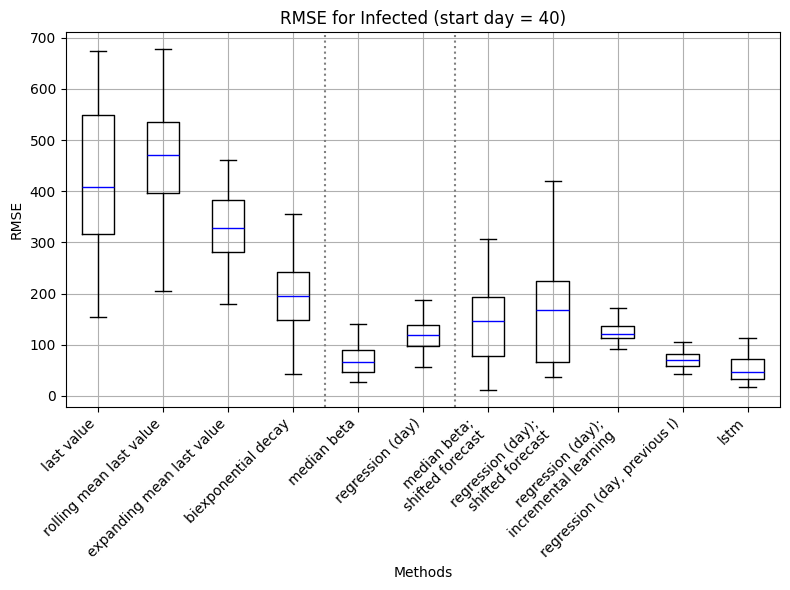

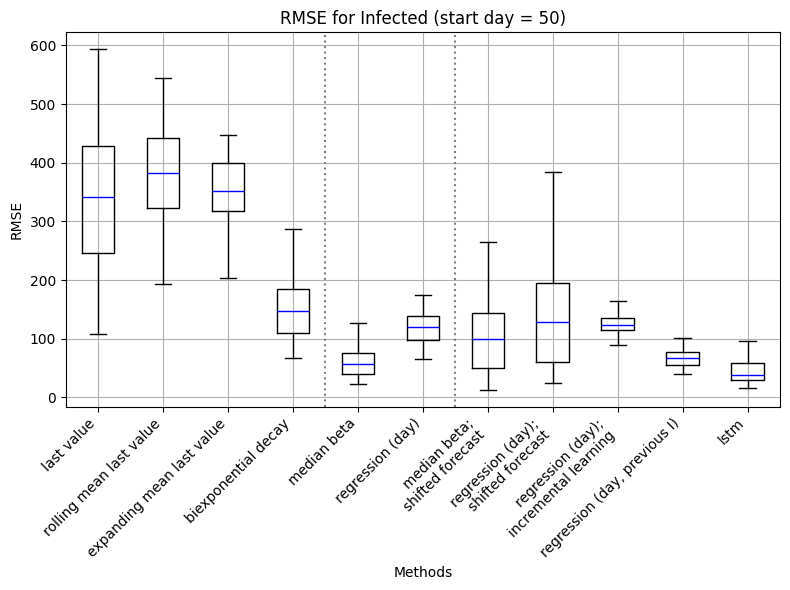

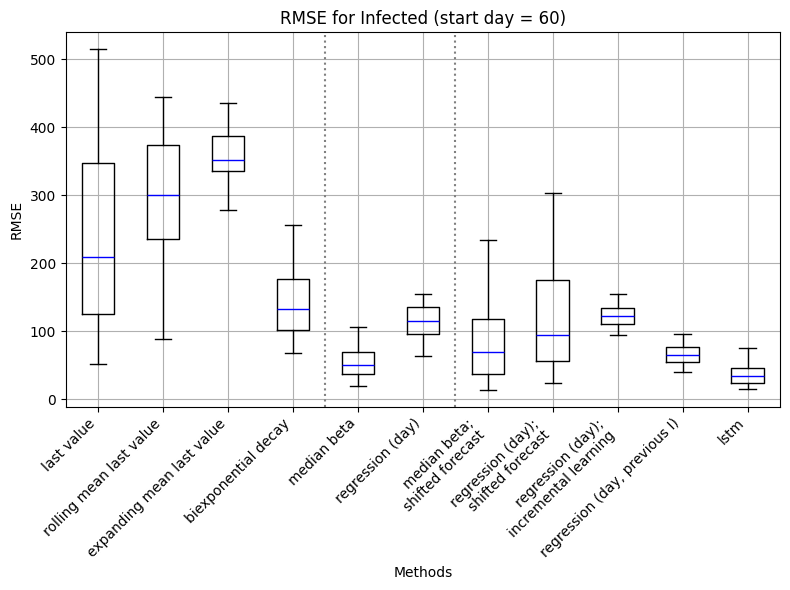

In [165]:
for day in days:
    # Загрузка данных из CSV
    rmse_df = pd.read_csv(f'RMSE/rmse_I_results_{day}_start.csv')

    # Создание боксплота
    plt.figure(figsize=(8,6))  # Установка размера графика
    box = plt.boxplot(rmse_df, showfliers=False, medianprops=dict(color='blue'))

    # Настройка заголовка и меток
    plt.title(f'RMSE for Infected (start day = {day})')
    plt.xlabel('Methods')
    plt.ylabel('RMSE')

    # Поворот меток по оси X для лучшей читаемости
    plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
            labels=methods, rotation=45, ha='right')

    plt.axvline(4.5, ls=':', color='gray')
    plt.axvline(6.5, ls=':', color='gray')

    # Показать график
    plt.tight_layout()  # Автоматическая настройка отступов
    plt.savefig(f'RMSE/rmse_I_boxplot_{day}_start.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.grid()
    plt.show()

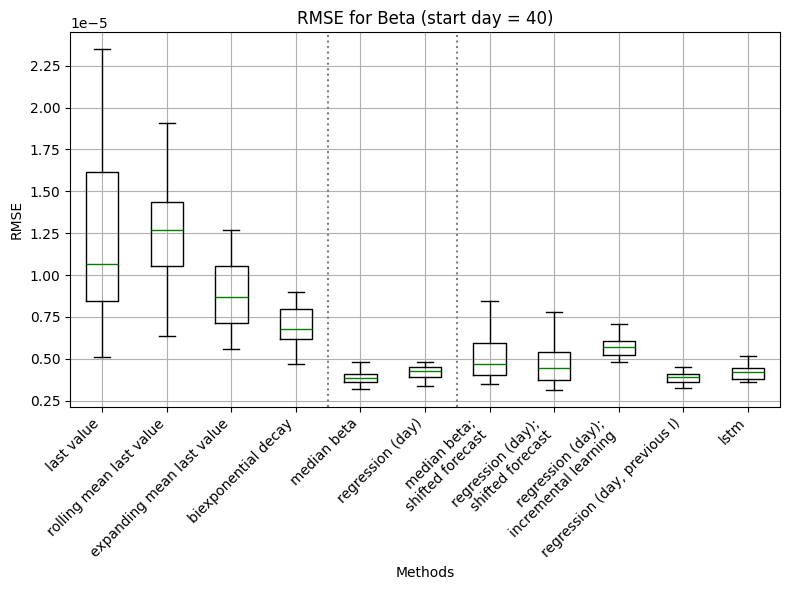

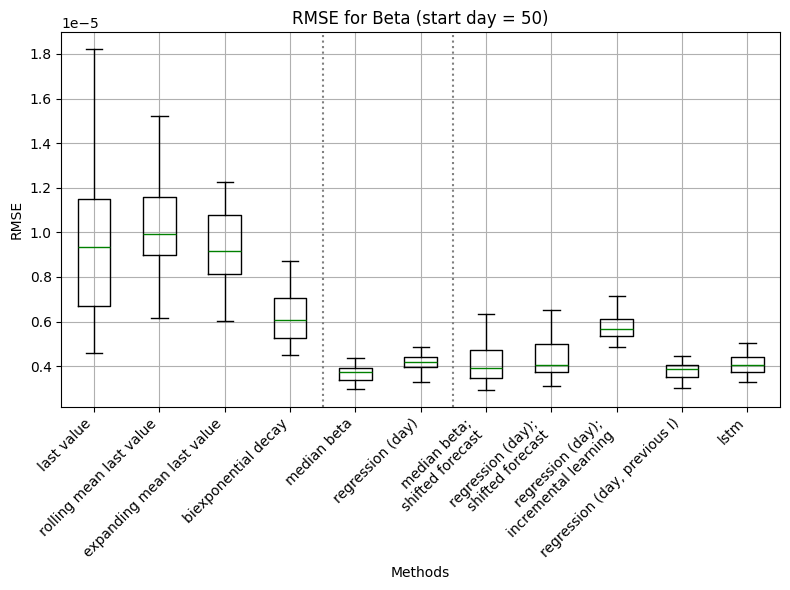

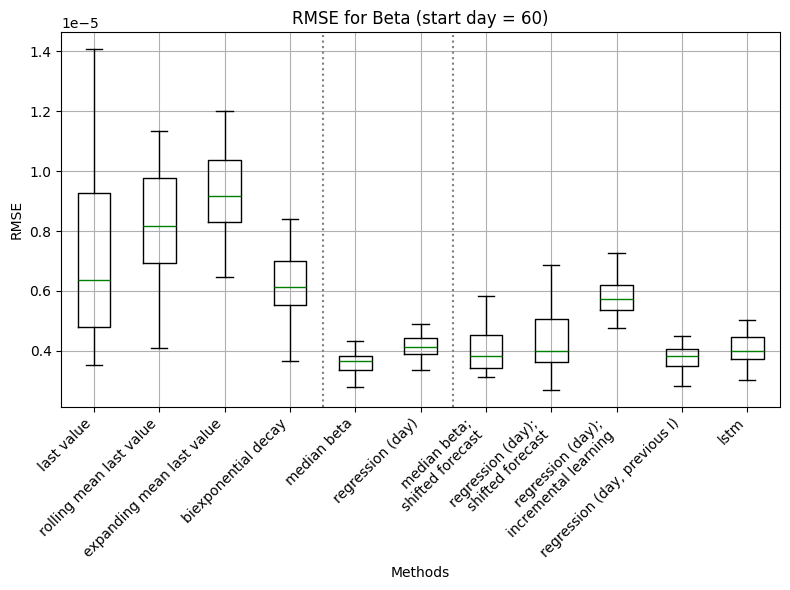

In [166]:
for day in days:
    # Загрузка данных из CSV
    rmse_df = pd.read_csv(f'RMSE/rmse_Beta_results_{day}_start.csv')

    # Создание боксплота
    plt.figure(figsize=(8,6))  # Установка размера графика
    box = plt.boxplot(rmse_df, showfliers=False, medianprops=dict(color='green'))

    # Настройка заголовка и меток
    plt.title(f'RMSE for Beta (start day = {day})')
    plt.xlabel('Methods')
    plt.ylabel('RMSE')

    # Поворот меток по оси X для лучшей читаемости
    plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
            labels=methods, rotation=45, ha='right')

    plt.axvline(4.5, ls=':', color='gray')
    plt.axvline(6.5, ls=':', color='gray')
 
    # Показать график
    plt.tight_layout()  # Автоматическая настройка отступов
    plt.savefig(f'RMSE/rmse_Beta_boxplot_{day}_start.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.grid()
    plt.show()


In [167]:
methods = [['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay'], 
        
        ['median beta',
        'regression (day)'],

        ['median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, previous I)',       
        'lstm']]

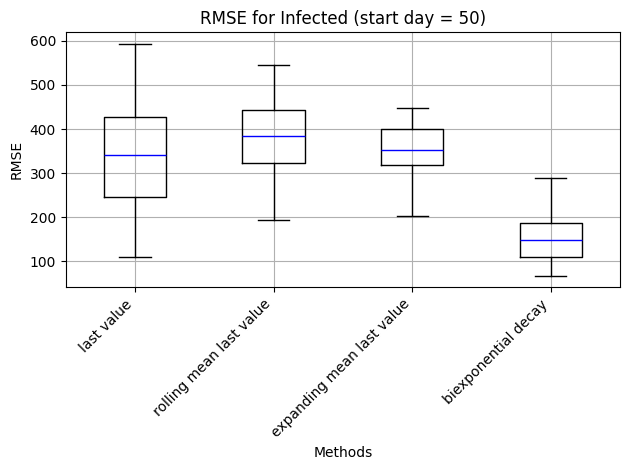

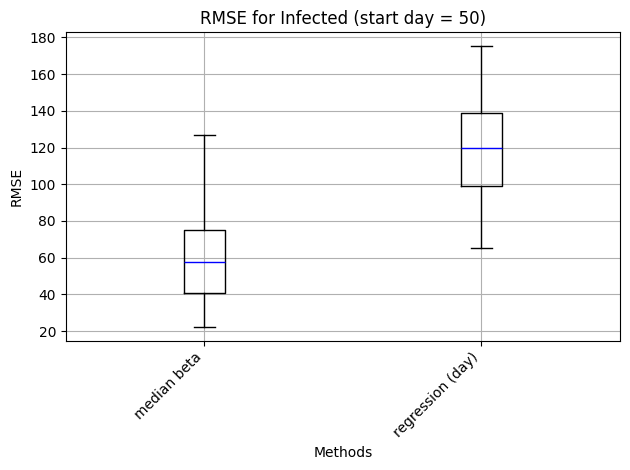

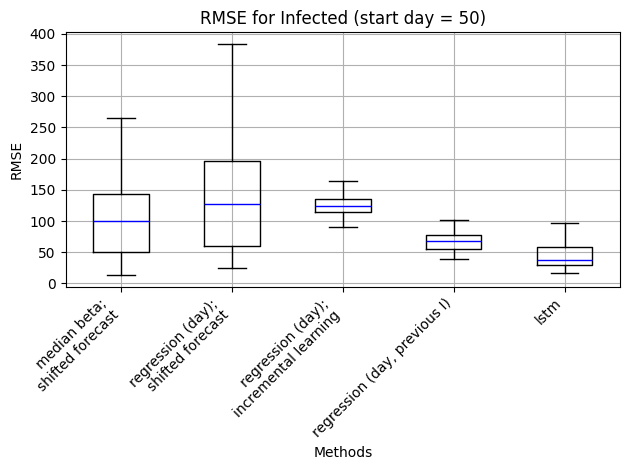

In [179]:
day = 50
# Загрузка данных из CSV
rmse_df = pd.read_csv(f'RMSE/rmse_I_results_{day}_start.csv')
for i in range(len(methods)):
    # Создание боксплота
    plt.figure()  # Установка размера графика
    box = plt.boxplot(rmse_df[methods[i]], showfliers=False, medianprops=dict(color='blue'))

    # Настройка заголовка и меток
    plt.title(f'RMSE for Infected (start day = {day})')
    plt.xlabel('Methods')
    plt.ylabel('RMSE')

    # Поворот меток по оси X для лучшей читаемости
    plt.xticks(ticks=np.arange(1, len(methods[i])+1), 
            labels=methods[i], rotation=45, ha='right')


    # Показать график
    plt.tight_layout()  # Автоматическая настройка отступов
    plt.savefig(f'RMSE/rmse_I_boxplot_{day}_start_group_{i}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.grid()
    plt.show()

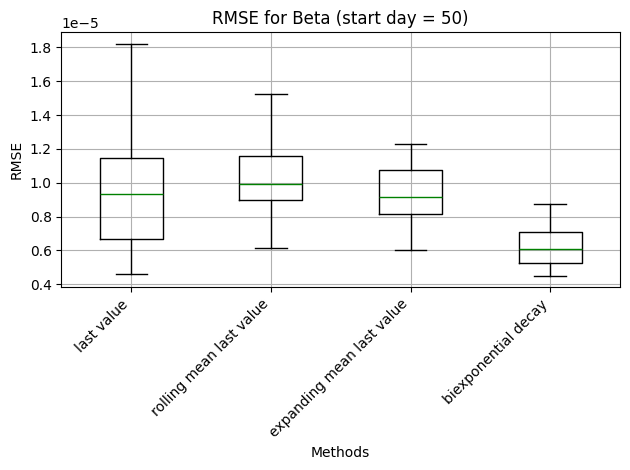

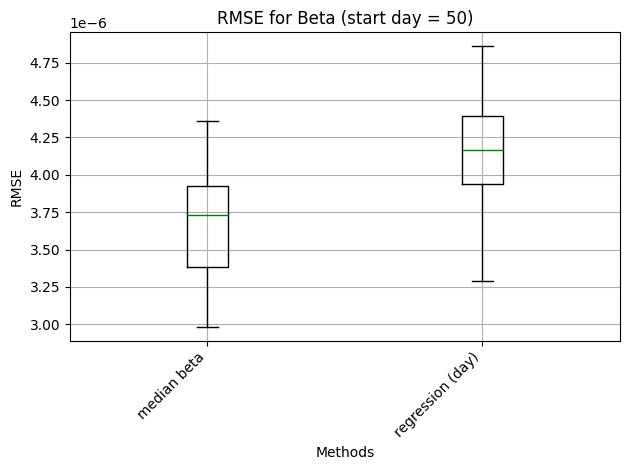

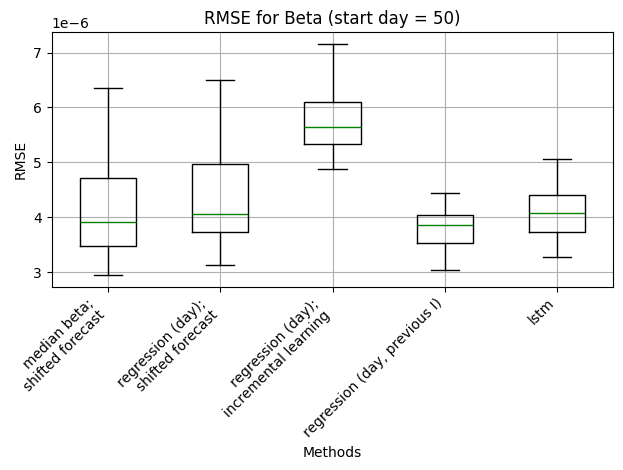

In [180]:
day = 50
# Загрузка данных из CSV
rmse_df = pd.read_csv(f'RMSE/rmse_Beta_results_{day}_start.csv')
for i in range(len(methods)):
    # Создание боксплота
    plt.figure()  # Установка размера графика
    box = plt.boxplot(rmse_df[methods[i]], showfliers=False, medianprops=dict(color='green'))

    # Настройка заголовка и меток
    plt.title(f'RMSE for Beta (start day = {day})')
    plt.xlabel('Methods')
    plt.ylabel('RMSE')

    # Поворот меток по оси X для лучшей читаемости
    plt.xticks(ticks=np.arange(1, len(methods[i])+1), 
            labels=methods[i], rotation=45, ha='right')


    # Показать график
    plt.tight_layout()  # Автоматическая настройка отступов
    plt.savefig(f'RMSE/rmse_Beta_boxplot_{day}_start_group_{i}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.grid()
    plt.show()

# RMSE peak I и day

Сохраняем RMSE peak I и day для некоторых beta_prediction_method

In [ ]:
seeds = set()
seeds.update(range(int(0), int(30)))
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, previous I)',       
        'lstm']
new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_previous_I',       
        'lstm']

for beta_prediction_method,new_labels in zip(methods, new_labels):
    _,_, peak_metrics_results = main_f('seir', False, 0, beta_prediction_method, 50, seeds)
    peak_metrics = pd.DataFrame(peak_metrics_results, columns = ['actual_peak_I', 'predicted_peak_I','actual_peak_day','predicted_peak_day'])
    peak_metrics.to_csv(f'peak_metrics/{new_labels}_peaks.csv', index=False)


Выводим точки RMSE peak I и day

In [4]:
new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_previous_I',       
        'lstm']

In [7]:
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, previous I)',       
        'lstm']

In [5]:
rmse_ph = []
rmse_pt = []
for name in new_labels:
    p_df = pd.read_csv(f'peak_metrics/{name}_peaks.csv')
    # rmse (y true, y pred)
    rmse_ph.append(rmse(p_df.iloc[:]['actual_peak_I'], p_df.iloc[:]['predicted_peak_I']))
    rmse_pt.append(rmse(p_df.iloc[:]['actual_peak_day'], p_df.iloc[:]['predicted_peak_day']))



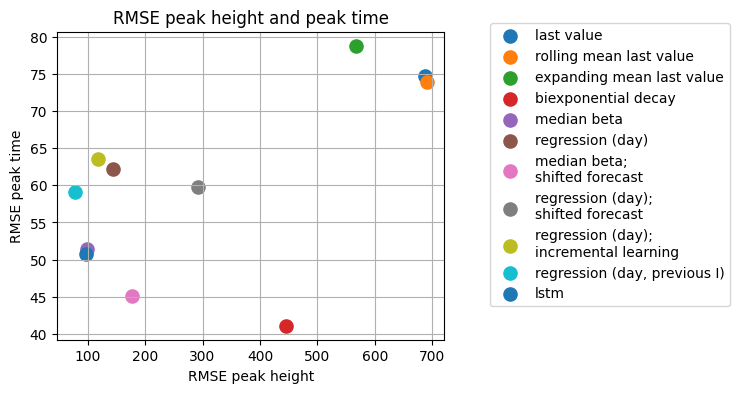

In [8]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))

for i, name in enumerate(methods):   
    ax.scatter(rmse_ph[i], rmse_pt[i], marker='o', s=90, label=name)
    
ax.set_title('RMSE peak height and peak time')    
ax.set_xlabel('RMSE peak height')
ax.set_ylabel('RMSE peak time')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.grid()

plt.savefig(f'rmse_peaks.pdf', format='pdf', dpi=300, bbox_inches='tight')
